Integrantes:

+ Igor Matos dos Santos Varejão - 2019107535 - imsvarejao@gmail.com

+ Vitor Berger Bonella - 2019107617 - vitorb.bonella36@gmail.com

OBS: Para rodar o notebook as instruçoes estão no README.

# Pré-processamento dos dados textuais

### Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Instala dependências

In [ ]:
!pip -q --disable-pip-version-check install pandas
!pip -q --disable-pip-version-check install unidecode
!pip -q --disable-pip-version-check install nltk
!pip -q --disable-pip-version-check install sklearn
!pip -q --disable-pip-version-check install seaborn
!pip -q --disable-pip-version-check install yellowbrick

     |████████████████████████████████| 235 kB 16.7 MB/s 
     |████████████████████████████████| 271 kB 32.1 MB/s 
     |████████████████████████████████| 14.8 MB 45.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np

from scipy.cluster import hierarchy

import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

#import limpeza dos dados
import nltk
import unidecode
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

#tamanho das imagens sns
sns.set(rc={'figure.figsize':(15,15)})

In [ ]:
path_to_data = '/content/drive/MyDrive/goodreads_books.json'
df_base = pd.read_json(path_to_data)

### Analisa distribuição do dataset

In [ ]:
counts = (df_base)['genre'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
names = counts['index'].values.tolist()
for i in range(len(names)):
    names[i] = names[i].replace('_', '\n')
print(names)

['romance', 'fantasy\nparanormal', 'history\nbiography', 'mystery\nthriller\ncrime', 'young\nadult', 'children', 'comics\ngraphic', 'poetry']


<BarContainer object of 8 artists>

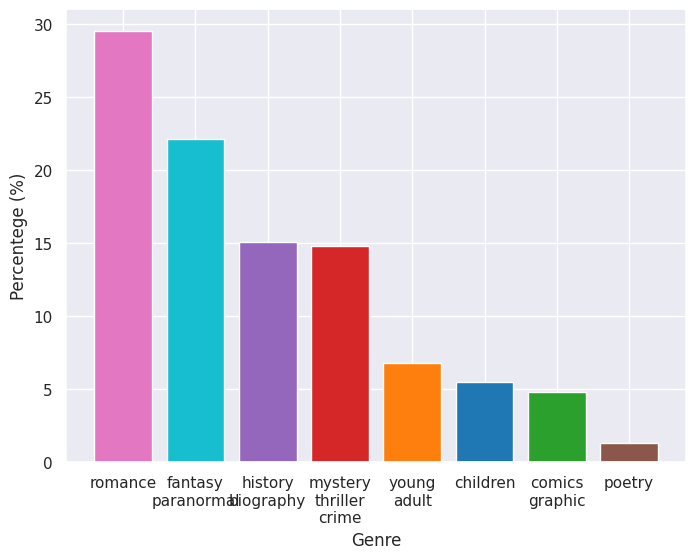

In [ ]:
plt.figure(figsize=(8, 6), dpi=100)
plt.xlabel('Genre')
plt.ylabel('Percentege (%)')
plt.bar(x=names, height=counts['percentage'], color=['tab:pink', 'tab:cyan', 'tab:purple', 'tab:red', 'tab:orange', 'tab:blue', 'tab:green', 'tab:brown'])


Nem todos os dados foram utilizados por falta de poder computacional, portanto, foi constatado que 2000 samples por gênero foi o número máximo de dados que a memória RAM suportou.

In [ ]:
df_mini = pd.DataFrame(data=None, columns=df_base.columns)
PER_GENRE = 2000
for g in df_base['genre'].unique():
    aux_df = df_base[df_base.genre == g].sample(PER_GENRE, random_state=7)
    df_mini = pd.concat([df_mini, aux_df], axis=0)
df_mini.head()

#df_mini = df_base

,book_id,description,genre,language_code
29584,27237230,"Laureate na nOg Eoin Colfer, author of the bes...",children,eng
27290,30267927,DreamWorks Animation's TROLLS is an irreverent...,children,eng
8046,16250909,Yoko and her mama are going on a trip to Japan...,children,eng
28484,17428684,Minnie and friends get ready to pamper their p...,children,eng
31456,30135659,One summer's day. ten-year-old India Opal Bulo...,children,eng


In [ ]:
str_labels = df_mini['genre'].unique()
dict_labels = {str_labels[l] :  l for l in range(len(str_labels))}
convert = lambda x: dict_labels[x]
df_mini['labels_numeric'] = df_mini['genre'].apply(convert)
df_mini['genre'].value_counts()

children                  2000
comics_graphic            2000
fantasy_paranormal        2000
history_biography         2000
mystery_thriller_crime    2000
poetry                    2000
romance                   2000
young_adult               2000
Name: genre, dtype: int64

## Limpeza dos dados

Um passo importante quando estamos analisando dados textuais é fazer uma limpeza para que possam ser extraidos do texto apenas o que adiciona valor e sentidos ao texto, neste caso ao tokenizar as palavras é muitos importante e não é necessario que pontuação, caracteres especiais, stopwords ou onomatopeia(não palavras) sejam considerados. 

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
def remove_specials(tokens):
    return [unidecode.unidecode(word) for word in tokens]

def remove_punctuation(tokens):
    table = str.maketrans("","",string.punctuation)
    return [w.translate(table) for w in tokens]

def array_lower(tokens):
    return [w.lower() for w in tokens]

def remove_no_words(tokens):
    return [word for word in tokens if word.isalpha()]

def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    return [w for w in tokens if not w in stop_words]

def text_clean(df_text_column, log=False):
    if log: print("Starting")

    # Dividindo texto em tokens
    df_text_column = df_text_column.apply(word_tokenize)

    if log: print("Tokens split done")  # Some log

    # Convertendo texto para minusculo
    df_text_column = df_text_column.apply(array_lower)

    if log: print("Upper letters converted to normal")

    # Removendo pontuação
    df_text_column = df_text_column.apply(remove_punctuation)

    if log: print("Removed punctiation")

    # Removendo caracteres especiais
    df_text_column = df_text_column.apply(remove_specials)

    if log: print("Specials chars removed")

    # Removendo tokens que não sao palavras
    df_text_column = df_text_column.apply(remove_no_words)

    if log: print("Removed non-words tokens")

    # Removendo tokens que são stop words
    df_text_column = df_text_column.apply(remove_stop_words)

    if log: print("Removed tokens that are stop-words\nFinished")

    return df_text_column


In [ ]:
df_mini['description'] = text_clean(df_mini['description'])
df_mini.head()

,book_id,description,genre,language_code,labels_numeric
29584,27237230,"[laureate, na, nog, eoin, colfer, author, best...",children,eng,0
27290,30267927,"[dreamworks, animation, trolls, irreverent, co...",children,eng,0
8046,16250909,"[yoko, mama, going, trip, japan, yoko, helps, ...",children,eng,0
28484,17428684,"[minnie, friends, get, ready, pamper, pets, mi...",children,eng,0
31456,30135659,"[one, summer, day, tenyearold, india, opal, bu...",children,eng,0


### Lemmazation

Decidimos usar o algoritmo de lemmização ao inves do de *stemmização*, apesar deles serem bem similares, preferimos utilizar o lemmizador pelo fato dele levar os tokens apenas para palavras existentes e não para tokens comuns as palavras e, dessa forma, ter chances menores de gerar palavras inexistentes computadas pelo algoritmo, algo que foi vislumbrado frequentemente no processo de **Stemmização**

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()
lemmazation = lambda words: [wordnet_lemmatizer.lemmatize(tk) for tk in words]
df_mini['description'] = df_mini['description'].apply(lemmazation)
df_mini.head()

,book_id,description,genre,language_code,labels_numeric
29584,27237230,"[laureate, na, nog, eoin, colfer, author, best...",children,eng,0
27290,30267927,"[dreamworks, animation, troll, irreverent, com...",children,eng,0
8046,16250909,"[yoko, mama, going, trip, japan, yoko, help, m...",children,eng,0
28484,17428684,"[minnie, friend, get, ready, pamper, pet, minn...",children,eng,0
31456,30135659,"[one, summer, day, tenyearold, india, opal, bu...",children,eng,0


# Construção da matriz de TF-IDF

Como visto em sala de aula a matriz TF-IDF é uma forma de representar textos a fim de compara-los. No que diz respeito aos nossos dados, está é uma boa forma de compararmos as descriçoes de cada livro. Não tomamos a decisão de usar n-grans pois aumentaria muito a quantidade de colunas da matriz dada a quantidade de tokens que existem. Todos termos raros que só aparecem em menos de 10 documentos foi descosiderado como uma forma de diminuir o numero de colunas, assim tambem como termos muito comuns aos documentos foram removidos (caso tivesse em mais de 95% dos documentos).

OBS: A biblioteca skleanr implementa TF-IDE, porém ela possui a mesma intuição da TF-IDF.

In [ ]:
do_nothing = lambda x: x
vect_manual = TfidfVectorizer(tokenizer=do_nothing, lowercase=False, preprocessor=do_nothing, ngram_range=(1, 1),min_df=10,max_df=0.95)
freq = vect_manual.fit_transform(df_mini['description'].values.tolist())
features = vect_manual.get_feature_names_out()
df_freq = pd.DataFrame(data=freq.todense(), columns=features)
df_freq.head()

,aaron,abandon,abandoned,abandoning,abandonment,abbey,abby,abc,abducted,abduction,abiding,abigail,ability,ablaze,able,aboard,abomination,aboriginal,abound,abraham,abridged,abroad,abrupt,abruptly,absence,absent,absolute,absolutely,absorbed,absorbing,abstract,absurd,absurdity,abundance,abuse,abused,abusive,abyss,academic,academy,...,year,yearn,yearning,yearns,yearold,yeats,yellow,yes,yesterday,yet,yield,yoga,york,yorker,yorkshire,young,younger,youngest,youngster,youth,youthful,youtube,yuri,z,zach,zack,zane,zany,zealand,zealot,zen,zero,zeus,zodiac,zoe,zoey,zombie,zone,zoo,zu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Redução de dimensionalidade, via PCA (Truncated SVD)

Diante da alta dimensionalidade dos dados na matriz de frequência **TFIDF**, uma vez que há grande variedade de palavras em nosso corpus, torna-se necessário reduzir a dimensionalidade para que o algoritmo de agrupamento seja capaz de extrair conhecimento dos dados. 

Apesar da grande dimensionalidade, a matriz é esparsa, logo, é viável usarmos o ***TruncatedSVD*** já que, diferente do *PCA*, ***essa ferramenta não centraliza os dados*** antes de computar o *SVD*, isso significa que consegue trabalhar com matrizes esparsas de forma eficiente.

É inviavel tentar agrupar utilizando a matriz inteira de dados, pois esta possui um numero muito grande, assim um numero razoavel de componentes é 800 que tem uma variancia explicada em torno de 40%, aumentar esse numero não melhora o agrupamento de forma significativa. 

In [ ]:
N_COMPONENTS = 800
pca = TruncatedSVD(n_components=N_COMPONENTS)

In [ ]:
pca.fit(df_freq)
print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")

Total variance explained: 40.37%


In [ ]:
freq_reduced = pca.transform(df_freq)
N_COMPONENTS = freq_reduced.shape[1]
df_freq_reduced = pd.DataFrame(data=freq_reduced, columns=list(range(N_COMPONENTS)))
df_freq_reduced.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799
0,0.159267,0.201447,-0.038972,0.077440,-0.006036,-0.047645,-0.043644,0.020678,0.069213,0.029900,0.075970,-0.033185,0.052702,0.006697,-0.077261,-0.002482,-0.033395,0.033032,0.005917,-0.026671,0.017281,0.010121,-0.031392,0.108084,-0.020686,-0.020089,-0.047792,0.045994,-0.003032,0.017345,0.056069,-0.006864,-0.032025,0.023058,0.043238,0.012374,0.072494,-0.010509,-0.027019,0.066716,...,-0.004645,-0.003554,0.008886,-0.019914,-0.014696,0.010960,-0.025166,-0.004634,-0.018243,0.007884,-0.010445,0.031237,-0.005701,-0.008610,-0.000213,-0.010652,0.003273,-0.007190,0.024266,0.011663,0.001942,0.003422,-0.017428,0.002716,-0.020451,-0.003989,-0.016621,-0.032469,0.004341,-0.009913,0.051690,0.008902,0.011143,0.013286,-0.021662,0.019330,0.009281,0.002452,-0.013487,0.003002
1,0.068609,0.013093,-0.031935,0.027047,0.002648,0.012251,-0.047407,-0.009639,0.000147,0.009364,0.000797,-0.008143,-0.023775,-0.019413,0.024636,0.023087,0.009389,-0.031324,-0.000756,-0.022204,0.003057,-0.009677,0.026735,-0.016487,-0.023654,-0.022969,0.004620,-0.005830,0.017134,-0.017842,0.015640,-0.015335,-0.023910,0.002274,0.020118,0.010036,-0.028610,0.023132,0.008965,0.029585,...,-0.014003,-0.015116,0.002487,0.033118,-0.010361,-0.020651,-0.007964,-0.003988,-0.003384,0.003380,0.018807,-0.012629,-0.010832,0.013180,-0.010978,-0.030835,-0.014930,0.044064,0.030920,0.004316,-0.041782,0.007565,-0.008786,-0.038541,-0.020682,0.000084,-0.045764,0.013289,0.004032,-0.014417,0.019982,0.005062,-0.006948,0.005955,-0.010502,0.007199,-0.014758,0.026280,0.026710,0.015606
2,0.090426,-0.006239,0.016695,0.063799,-0.010080,0.007857,-0.020605,-0.002224,-0.012989,0.020981,0.037190,0.006141,-0.000477,-0.033738,-0.007056,-0.013399,-0.017242,-0.006540,0.051684,0.017635,0.026659,-0.004444,0.003366,-0.014281,-0.021223,-0.000880,-0.031839,-0.003403,-0.008036,-0.022961,0.002353,0.047067,0.003985,0.013895,0.019595,-0.040451,-0.002256,0.009979,-0.040227,-0.013928,...,-0.017624,-0.016441,0.009053,-0.022841,0.000489,0.034864,0.024538,-0.022500,-0.023881,0.021426,0.033297,-0.000177,-0.052080,0.025511,-0.015830,-0.003188,0.002652,0.020296,0.061660,0.020584,-0.005237,-0.003942,0.035963,-0.006434,-0.007580,0.046880,-0.014634,-0.013312,0.018928,0.055611,0.018443,-0.034174,0.000063,0.039686,-0.047215,-0.005708,-0.003273,-0.014325,0.020545,-0.063781
3,0.106448,0.021517,0.007790,0.139232,0.009667,-0.029118,-0.064524,-0.029249,-0.020402,0.034771,0.050414,0.000806,-0.030163,0.003211,0.019604,-0.013734,-0.032124,-0.024489,0.125497,0.037325,0.045107,-0.024764,-0.020320,0.120660,0.041776,-0.023421,0.014787,0.023613,-0.019640,-0.010816,0.006203,0.036492,-0.047771,-0.002780,-0.020813,0.018425,0.011324,-0.004317,-0.036696,0.022127,...,-0.010141,0.008399,0.025783,-0.012501,-0.004968,-0.020776,0.008887,-0.015859,-0.013772,0.001636,0.006874,0.005575,0.003968,-0.016566,-0.007332,-0.019189,-0.016537,-0.009964,0.009767,0.003879,0.001302,-0.003616,0.011481,0.007828,0.009672,-0.001408,0.026792,-0.003610,-0.011159,0.020439,0.017205,0.007739,-0.009298,0.013283,-0.022781,-0.017303,0.023849,-0.001673,-0.022586,-0.009477
4,0.141501,-0.048641,0.030055,0.039963,-0.044861,-0.063679,-0.086534,-0.042568,0.003882,0.008823,-0.024223,-0.007722,-0.012671,-0.033500,-0.007746,0.047761,-0.014145,0.047479,0.051627,0.040075,-0.017736,-0.037182,0.055164,0.015587,0.025062,0.011146,0.026224,0.008911,-0.074542,-0.028516,0.008474,0.003038,-0.058942,-0.026471,-0.060588,0.012355,-0.027025,0.007725,-0.029346,-0.037654,...,-0.010836,-0.004365,-0.038199,0.011812,0.018164,0.002329,0.004648,-0.016350,0.005272,-0.003198,0.013957,0.006196,0.010891,0.017959,0.016752,0.005256,-0.008130,-0.013199,0.008966,-0.001392,-0.003960,-0.001549,-0.020473,-0.010552,-0.011877,-0.012066,0.006841,0.010690,0.01401

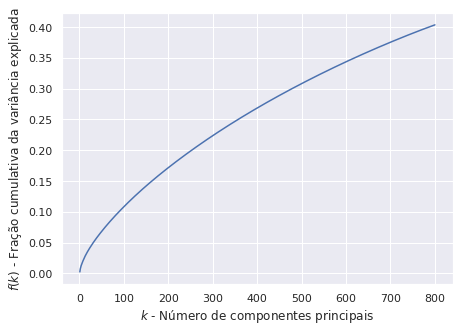

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, N_COMPONENTS + 1)], np.cumsum(pca.explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada');

# Aplicação de ao menos dois algoritmos de agrupamento vistos na disciplina

## Analise da Quantidade de Grupos

### Elbow Method

Precisamos descobrir o $K$ ideal, dessa forma, iremos utilizar o método do $Elbow$ que irá ajustar o modelo com um intervalo de valores de $K$. Os demais metodos para descobrir a quantidade de grupos não tiverem resultados conclusivos, assim preferimos oculta-las do trabalho.

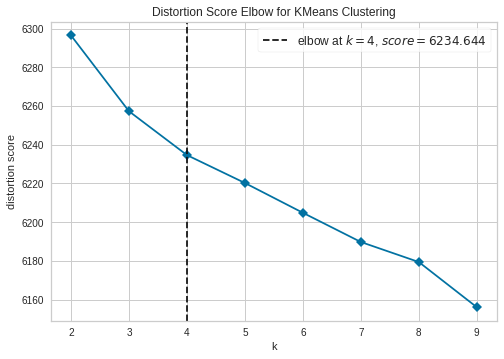

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(init='k-means++', random_state = 42)

visualizer = KElbowVisualizer(model, k=(2,10), timings=False)
visualizer.fit(df_freq_reduced.values)
visualizer.show()

### Dendograma

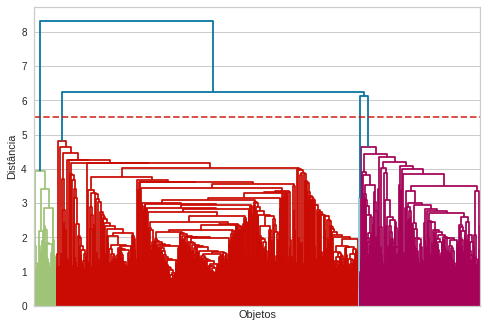

In [ ]:
Z = hierarchy.linkage(df_freq_reduced.values, 'ward')
plt.figure()
dn = hierarchy.dendrogram(Z, no_labels=True, color_threshold=5.5)
plt.axhline(y=5.5, color='r', linestyle='--', alpha=0.8)
plt.xticks([], [])
plt.ylabel('Distância')
plt.xlabel('Objetos');

## K-means


Como pode ser observado pelo $ \texttt{elbow method} $, o numero ideal de grupos é 4. Assim, aplicar o k-means com 4 centros(grupos) pode ajudar em obter um agrupamento agradavel.

In [ ]:
num_labels = df_mini['genre'].unique().size
print("Number of labels: ", num_labels)

Number of labels:  8


In [ ]:
N_CLUSTERS = 4
model = KMeans(n_clusters=N_CLUSTERS, random_state=42)
y_pred_k_means = model.fit_predict(df_freq_reduced)
y_pred_k_means

array([0, 1, 1, ..., 1, 1, 1], dtype=int32)

Text(0.5, 0, 'Groups')

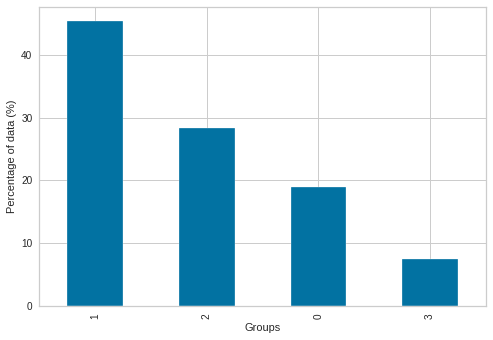

In [ ]:
df_mini['pred_k_means'] = y_pred_k_means

df_mini['pred_k_means'].value_counts(normalize=True).mul(100).plot(kind = 'bar')
plt.ylabel("Percentage of data (%)")
plt.xlabel("Groups")

Podemos observar que o k-means distruibuiu a quantidade de livros por grupos de forma desigual, tendo o grupo 3 mais de 40% dos dados, ainda assim não é o suficiente para dizer algo conclusivo.

## Agrupamento Hierarquico

Pelo dendograma, vemos que, com a medida 'ward', um boa escolha para o número de grupos está no intervalo de $[4, 5]$, pois ao traçar uma linha horizontal obtemos um agrupamento menos espaçado formando 4 grupos. Além disso, a medida ***Ward*** foi escolhida para calcular as distancias entre os grupos, uma vez que essa medida prima por gerar grupos que possuem **alta homogenidade interna**, propriedade carente nos resultados subsequentes (grupos pouco homogêneos).

In [ ]:
model = AgglomerativeClustering(N_CLUSTERS, linkage = 'ward')
y_pred_ah = model.fit_predict(df_freq_reduced)
y_pred_ah

array([1, 0, 0, ..., 0, 0, 0])

Text(0.5, 0, 'Groups')

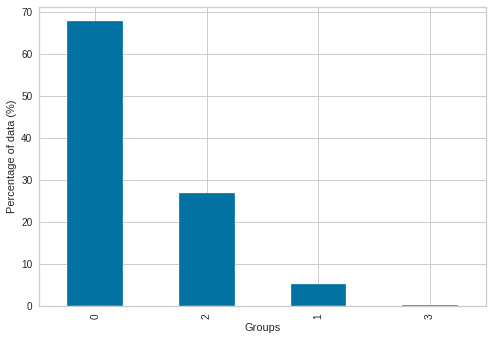

In [ ]:
df_mini['y_pred_ah'] = y_pred_ah

df_mini['y_pred_ah'].value_counts(normalize=True).mul(100).plot(kind = 'bar')
plt.ylabel("Percentage of data (%)")
plt.xlabel("Groups")

Podemos ver que o agrupamento hierarquico classificou mais de 60% do conjunto em um grupo, o que pode indicar um mal agrupamento dos dados.

# Validação da metodologia utilizada

#### K-Means

Dado o agrupamento realizado podemos avaliá-lo visualmente a partir da distribuição de classes em cada $cluster$

[Text(0.5, 0, 'Cluster Number')]

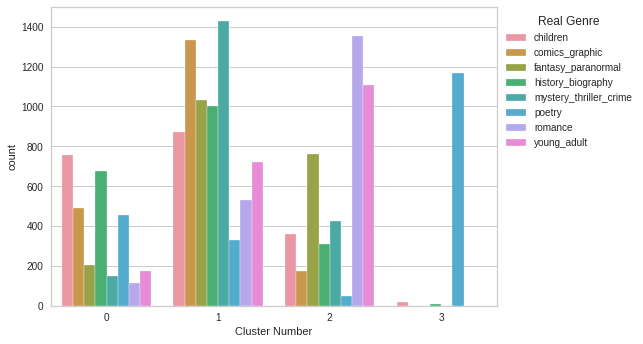

In [ ]:
p = sns.countplot(data=df_mini, x='pred_k_means', hue='genre')
p.legend(title='Real Genre', bbox_to_anchor=(1, 1), loc='upper left')
p.set(xlabel='Cluster Number')

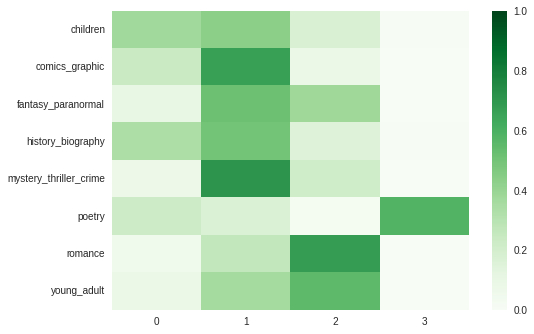

In [ ]:
df_heatmap = pd.DataFrame()
for genre in df_base['genre'].unique():
    df_aux = df_mini[df_mini.genre == genre]
    lista = []
    for i in range(N_CLUSTERS):
      lista.append(len(df_aux[df_aux.pred_k_means == i]))
    
    list_norm = [float(val)/sum(lista) for val in lista]
    df_heatmap[genre] = list_norm
    
 


df_transposed = df_heatmap.transpose()
sns.heatmap(df_transposed,vmin = 0, vmax=1,cmap="Greens")

Nas Figuras de distribuição de classe por grupo é possivel observar de forma clara que houve um agrupamento relativamente bom dependendo da descrição dos livros. 

Um grupo tem predominantemente a classe litararia "children" e depois outros que tem alguma relação com isso como "history","poetry" e "comics", pois palavras infantis podem ser usadas nesses estilos citados. 

Outro grupo possui predominantemente os estilos literarios "romance" e "young_adult", o que pode indicar um bom agrupamento uma vez que esses dois temas possuem certe similaridade ou podem conter uma a outra. O genero "fantasy_paranormal" tambem aparece de certa forma neste grupo.

Existe grupo que é o mais legal, pois ele indica claramente que "poetry" possui uma descrição facilmente distinguivel das demais e de facil agrupamento.

Outro grupo é predominado por varias classes, porém a que mais aparece é "mystery_thriller_crime" e "comics_graphic". No geral esses generos podem ser relacionados pois historias em quadrinhos podem conter palavras bem relacionadas a este tema.

O agrupamento como um todo não produziu um isolamento claro entre os generos porém podemos dizer que a descrição do livro tem relação com seu genero, porém generos similares podem conter uma mesma linguagem ou conjunto de palavras fazendo assim ser dificil agrupar os generos apenas pela frequencia de palavras.

##### Completude e Homogenidade

Outra métrica do agrupamento que podemos analisar é:
+ **Homogenidade**: 
A homogenidade de um agrupamento mede se todos os cluster contém apenas dados de uma classe apenas;
+ **Completude**: 
A completude de um agrupamento mede se os samples de uma mesma classe estão no mesmo $cluster$, no qual a métrica retorna um valor no intervalo $\{0, 1\}$, tal qual retornará $1$ caso todos os cluster tenham apenas uma classe.

In [ ]:
from sklearn.metrics import homogeneity_score, completeness_score
print("Homogeneity: {:.2f}%".format(homogeneity_score(df_mini['labels_numeric'].values, y_pred_k_means) * 100))
print("completeness_score: {:.2f}%".format(completeness_score(df_mini['labels_numeric'].values, y_pred_k_means) * 100))

Homogeneity: 14.57%
completeness_score: 24.74%


A partir dos resultados das métricas notamos que o agrupamento foi pouco homogêneo e completo

##### Visualização do agrupamento

In [ ]:
pca2d = PCA(n_components=2)

X_2d = pca2d.fit_transform(df_freq.values)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


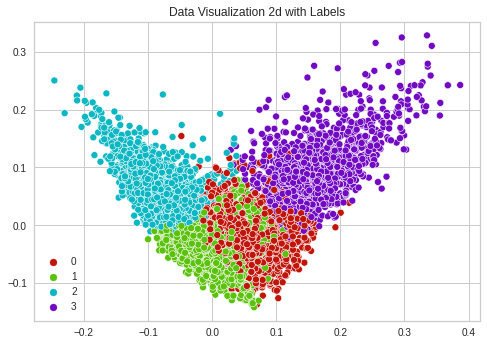

In [ ]:
# colors
palette = sns.hls_palette(N_CLUSTERS, l=.4, s=.9)

# plot
sns.scatterplot(X_2d[:,0], X_2d[:,1], palette=palette, hue=y_pred_k_means, legend='full')
plt.title('Data Visualization 2d with Labels')
plt.savefig("pca_good_reads.png")
plt.show()

Utilizando o PCA para reduzir a dimensionalidade para ficarmos com um grafico visivel em 2d, podemos observar que há certa estrutura de 4 grupos nos dados de fato e o k-means consegiu agrupa-los de forma correta (considerando os dados), desconsiderando algum ruído que aparece porém com mais dimensões deve sumir.

#### Agrupamento Hierarquico

[Text(0.5, 0, 'Cluster Number')]

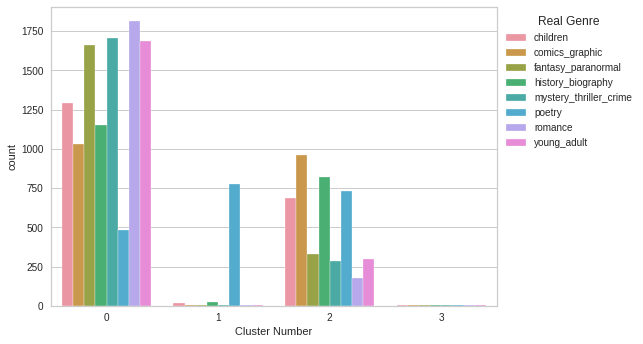

In [ ]:
p = sns.countplot(data=df_mini, x='y_pred_ah', hue='genre')
p.legend(title='Real Genre', bbox_to_anchor=(1, 1), loc='upper left')
p.set(xlabel='Cluster Number')

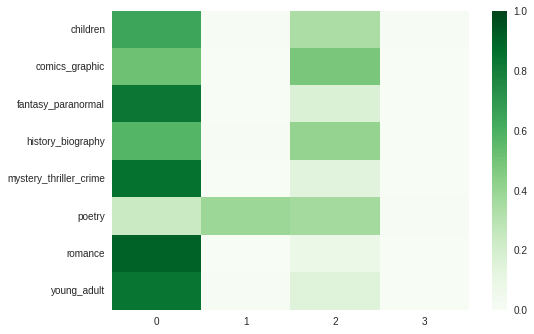

In [ ]:
df_heatmap = pd.DataFrame()
for genre in df_base['genre'].unique():
    df_aux = df_mini[df_mini.genre == genre]
    lista = [len(df_aux[df_aux.y_pred_ah == 0]),
             len(df_aux[df_aux.y_pred_ah == 1]),
             len(df_aux[df_aux.y_pred_ah == 2]),
             len(df_aux[df_aux.y_pred_ah == 3])]
    
    list_norm = [float(val)/sum(lista) for val in lista]
    df_heatmap[genre] = list_norm
    
 
df_transposed = df_heatmap.transpose()
sns.heatmap(df_transposed,vmin = 0, vmax=1,cmap="Greens")

O agrupamento hierarquico conseguiu diferenciar a classe "poetry" porém os demais grupos ficaram muito juntos e confusos. Além de um grupo com quase nenhum caso

##### Completude e Homogenidade

Outra métrica do agrupamento que podemos analisar é:
+ **Homogenidade**: 
A homogenidade de um agrupamento mede se todos os cluster contém apenas dados de uma classe apenas;
+ **Completude**: 
A completude de um agrupamento mede se os samples de uma mesma classe estão no mesmo $cluster$, no qual a métrica retorna um valor no intervalo $\{0, 1\}$, tal qual retornará $1$ caso todos os cluster tenham apenas uma classe.

In [ ]:
from sklearn.metrics import homogeneity_score, completeness_score
print("Homogeneity: {:.2f}%".format(homogeneity_score(df_mini['labels_numeric'].values, y_pred_ah) * 100))
print("completeness_score: {:.2f}%".format(completeness_score(df_mini['labels_numeric'].values, y_pred_ah) * 100))

Homogeneity: 7.91%
completeness_score: 20.90%


Notamos que o agrupamento hierárquico é menos homogêneo e menos completo que o agrupemento realizado pelo **k-means**

##### Visualização do agrupamento

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


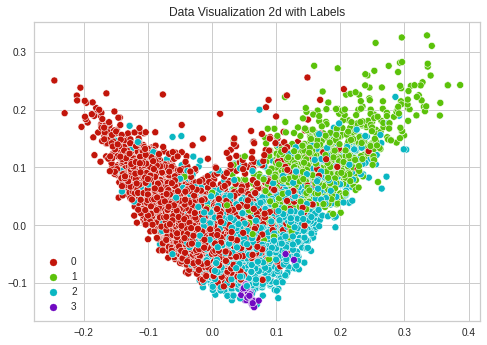

In [ ]:
# colors
palette = sns.hls_palette(N_CLUSTERS, l=.4, s=.9)

# plot
sns.scatterplot(X_2d[:,0], X_2d[:,1], palette=palette, hue=y_pred_ah, legend='full')
plt.title('Data Visualization 2d with Labels')
plt.savefig("pca_good_reads.png")
plt.show()

Pelo fato dos pontos estarem bem proximos, o agrupamento hierarquico não fez um bom trabalho ao tentar agrupar os dados, sendo assim inconclusivo. Além de um grupo muito pequeno.

# Considerações Finais

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


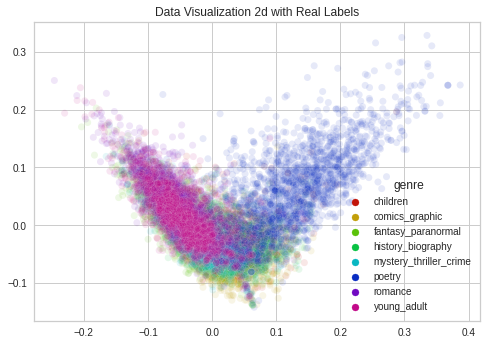

In [ ]:
# colors
palette = sns.hls_palette(8, l=.4, s=.9)

# plot
sns.scatterplot(X_2d[:,0], X_2d[:,1], palette=palette, hue=df_mini['genre'], legend='full', alpha=0.1)
plt.title('Data Visualization 2d with Real Labels')
plt.show()

É legal observarmos que existe uma separação nitida apenas plotando entre o grupo "poetry" e os demais reduzindo a TF-IDF com pca para 2 dimensões. E existem outros grupos que estão bem sobrepostos mesmo indicando que possa haver certa similaridade de palavras entre as descrições.

Podemos concluir com esse trabalho que nem sempre os dados possuem as informações bem definidas, assim tivemos que extrair e observar como se comportavam os algoritmos propostos durante as aulas e fazer uma analise dos dados. O uso do PCA foi de extrema importância pois ao reduzir significamente a dimensionalidade podemos utilizar as técnicas computacionais de forma mais livre, além de poder gerar visualizações legais.

Neste caso o k-means foi superior ao agrupamento hierárquico pelo fato de conseguir separar melhor os grupos de forma que faz algum sentido (classes que podem ter "palavras mais utilizadas iguais"), além de ver que o genero "poetry" tem uma distinção clara no uso de palavras dos demais gêneros. 

Analisando apenas a frequência das palavras dos documentos foram obtidos resultados inconclusivos, uma vez que apenas o grupo $\textit{poetry}$ apresentou informações decisivas para seu agrupamento. Contudo, sabemos que o grande fator diferencial desse grupo é o linguajar desse genêro, que usa palavras mais rebruscadas, o que torna a matriz de frequência um processamento interessante para o agrupamento desse gênero, algo que não se pode dizer para os demais. Dessa forma, é interessante abordagens diferentes para o agrupamento desses outros gêneros, tal qual PLN, deep learning, que consigam analisar a semântica do texto, dado que o uso de palavras não difere de forma tão drástica para, assim, termos um agrupamento mais homogêneo e completo.

Vale ressaltar que nem todos os dados foram utilizados por falta de poder computacional, foram utilizados 2000 entradas de cada classe, é possível que com o aumento dos dados apareça informações interessantes para o agrupamento. Mas com a atual conjuntura dos dados essa é a análise que pode ser feita.